# Imports and Defaults

In [1]:
import os
from functools import lru_cache

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_theme(font_scale=1.6, style="whitegrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.dpi": 300,
})

seed = 1234
rng = np.random.default_rng(seed)

# Load Data

In [3]:
fname = "../../data/funnel50/baseline"

drghmc_sampler = "adapt_metric=False__damping=0.08__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drghmc__step_count_method=const_step_count__step_size_factor=2"
drhmc_sampler = "adapt_metric=False__damping=1.0__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drhmc__step_count_factor=0.6__step_size_factor=2"

nuts_sampler = "adapt_metric=False__metric=identity__sampler_type=nuts"
nuts2_sampler = "adapt_metric=True__metric=identity__sampler_type=nuts"

In [4]:
def get_fname(sampler, chain):
    return os.path.join(fname, sampler, f"history__chain={chain}.npz")

def get_chain_data(sampler, chain):
    data = np.load(get_fname(sampler, chain))
    # print(np.percentile(data["step_count"], 60))
    return data["draws"][:, 0]

In [7]:
@lru_cache(maxsize=3)
def get_data(sampler):
    data_list = []
    for chain in range(100):
        data_list.append(get_chain_data(sampler, chain))
    return np.concatenate(data_list)


In [8]:
drhmc_data = get_data(drhmc_sampler)
drghmc_data = get_data(drghmc_sampler)
nuts_data = get_data(nuts_sampler)
true = rng.normal(0, 3, 100000)

: 

In [ ]:
print(drhmc_data.shape)
print(drghmc_data.shape)
print(nuts_data.shape)

(447861,)
(33827136,)
(1749199,)


In [ ]:
data = pd.DataFrame({
    "values": np.concatenate([drghmc_data, drhmc_data, nuts_data]),
    "sampler": ["DR-G-HMC"] * len(drghmc_data) + ["DR-HMC"] * len(drhmc_data) + ["NUTS"] * len(nuts_data)
})

# Final Plot

In [ ]:
drghmc_mean, drghmc_std = np.mean(drghmc_data), np.std(drghmc_data)
drhmc_mean, drhmc_std = np.mean(drhmc_data), np.std(drhmc_data)
nuts_mean, nuts_std = np.mean(nuts_data), np.std(nuts_data)

In [ ]:
print(drghmc_mean, drghmc_std)
print(drhmc_mean, drhmc_std)
print(nuts_mean, nuts_std)

-0.0260011893100427 2.8291680459765534
-0.0027444558391838307 2.96303983495859
0.16415633089022205 2.7477738805361493


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


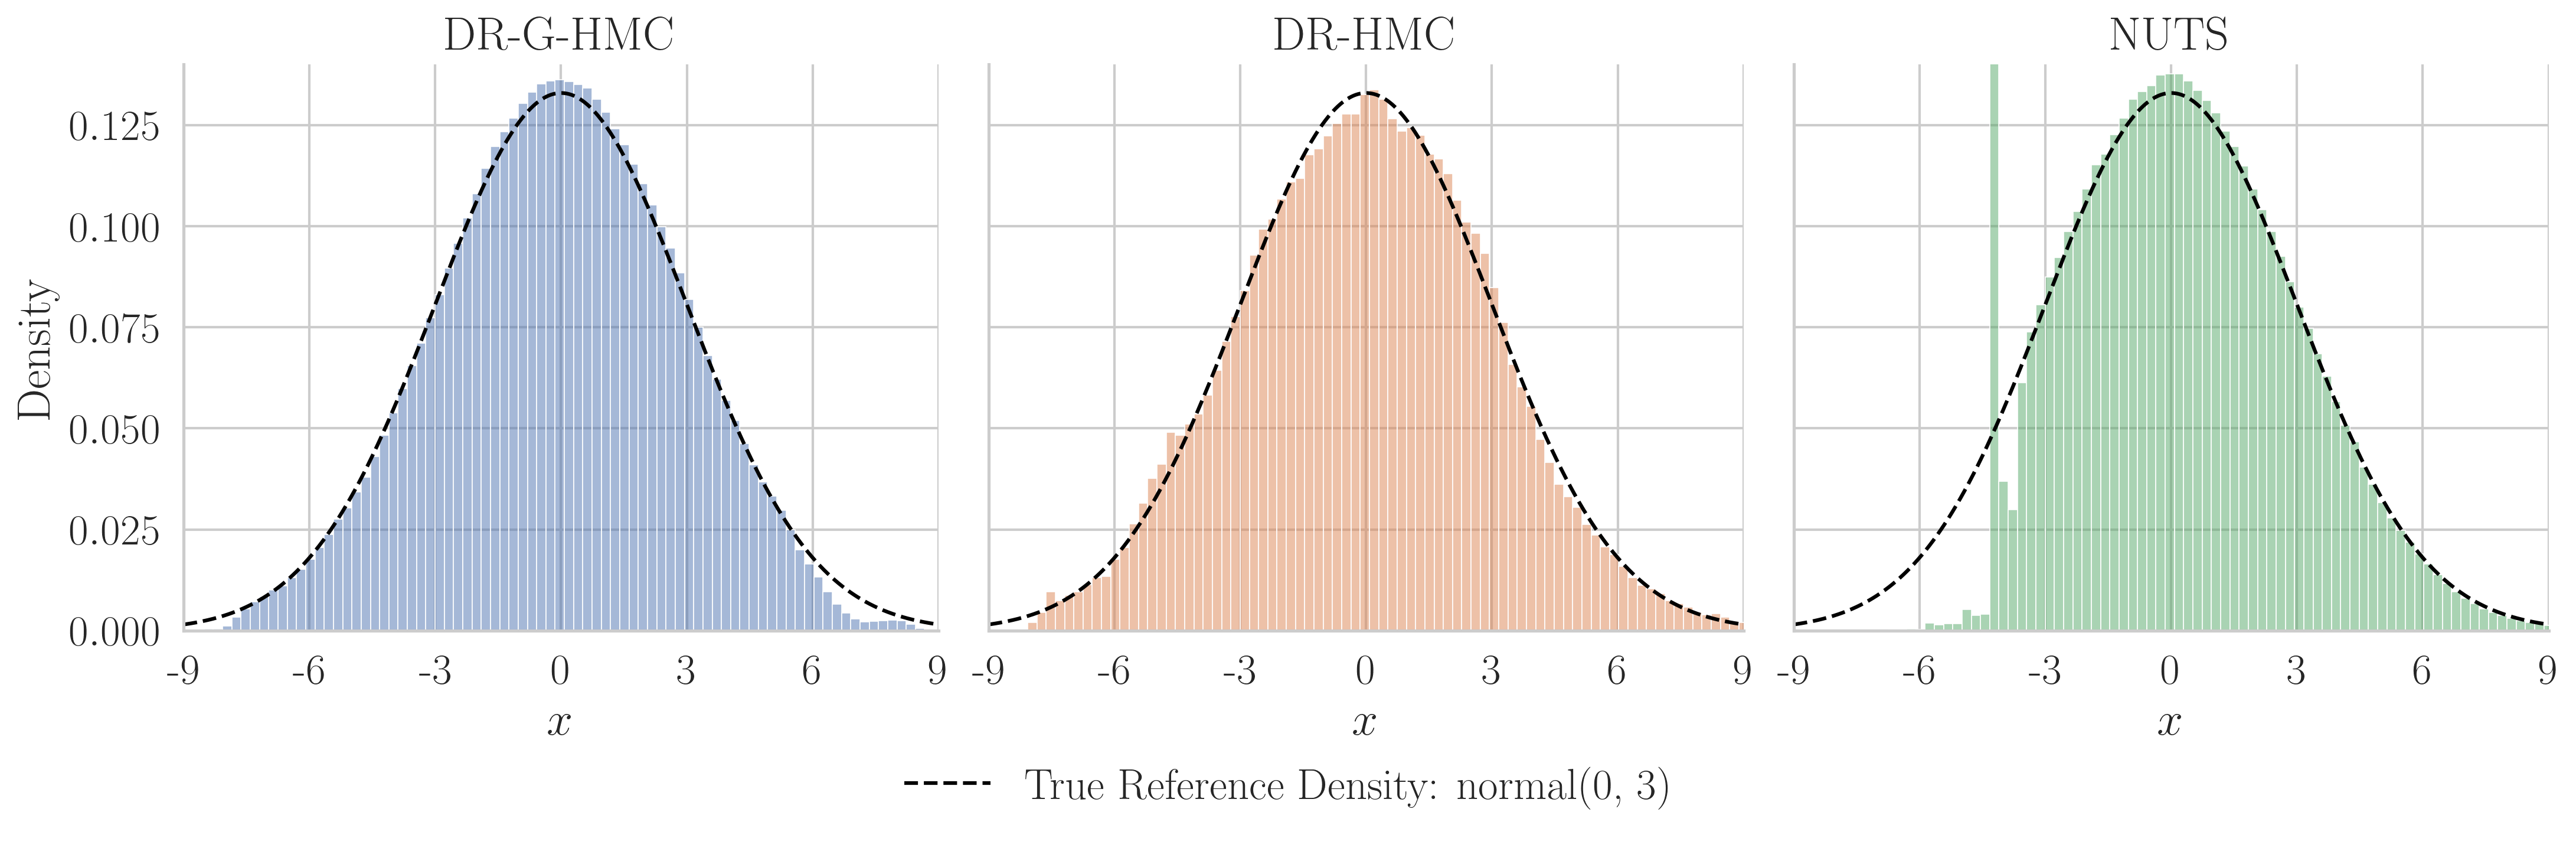

In [ ]:
fig = sns.displot(
    data=data,
    kind="hist",
    x="values",
    hue="sampler",
    hue_order=["DR-G-HMC", "DR-HMC", "NUTS"],
    stat="density",
    common_norm=False,
    col="sampler",
    bins=100,
    aspect=1,
    facet_kws={"ylim": (0, 0.14), "xlim": (-9, 9)},
    legend=False,
)

fig.set_xlabels(r"$x$")
fig.set_titles("{col_name}")

# set x axis ticks
for ax in fig.axes.flat:
    ax.set_xticks(np.arange(-9, 10, 3))
    ax.set_xticklabels([f"{x}" for x in np.arange(-9, 10, 3)])

# plot the true distribution on every axis
x_values = np.linspace(-9, 9, 1000) # normal distribution with mean 0 and std 3
y_values = 1 / np.sqrt(2 * np.pi * 3**2) * np.exp(-x_values**2 / (2 * 3**2))
for ax in fig.axes.flat:
    ax.plot(x_values, y_values, color="black", linestyle="--", label="Reference")

ref_line = plt.Line2D([0], [0], color="black", linestyle="--", label="Reference")
legend_dict = fig._legend_data | {"True Reference Density: normal(0, 3)": ref_line}
fig.add_legend(legend_data=legend_dict)

fig.figure.subplots_adjust(bottom=0.25)
sns.move_legend(fig, "lower center", ncol=4, title="")


# Plot

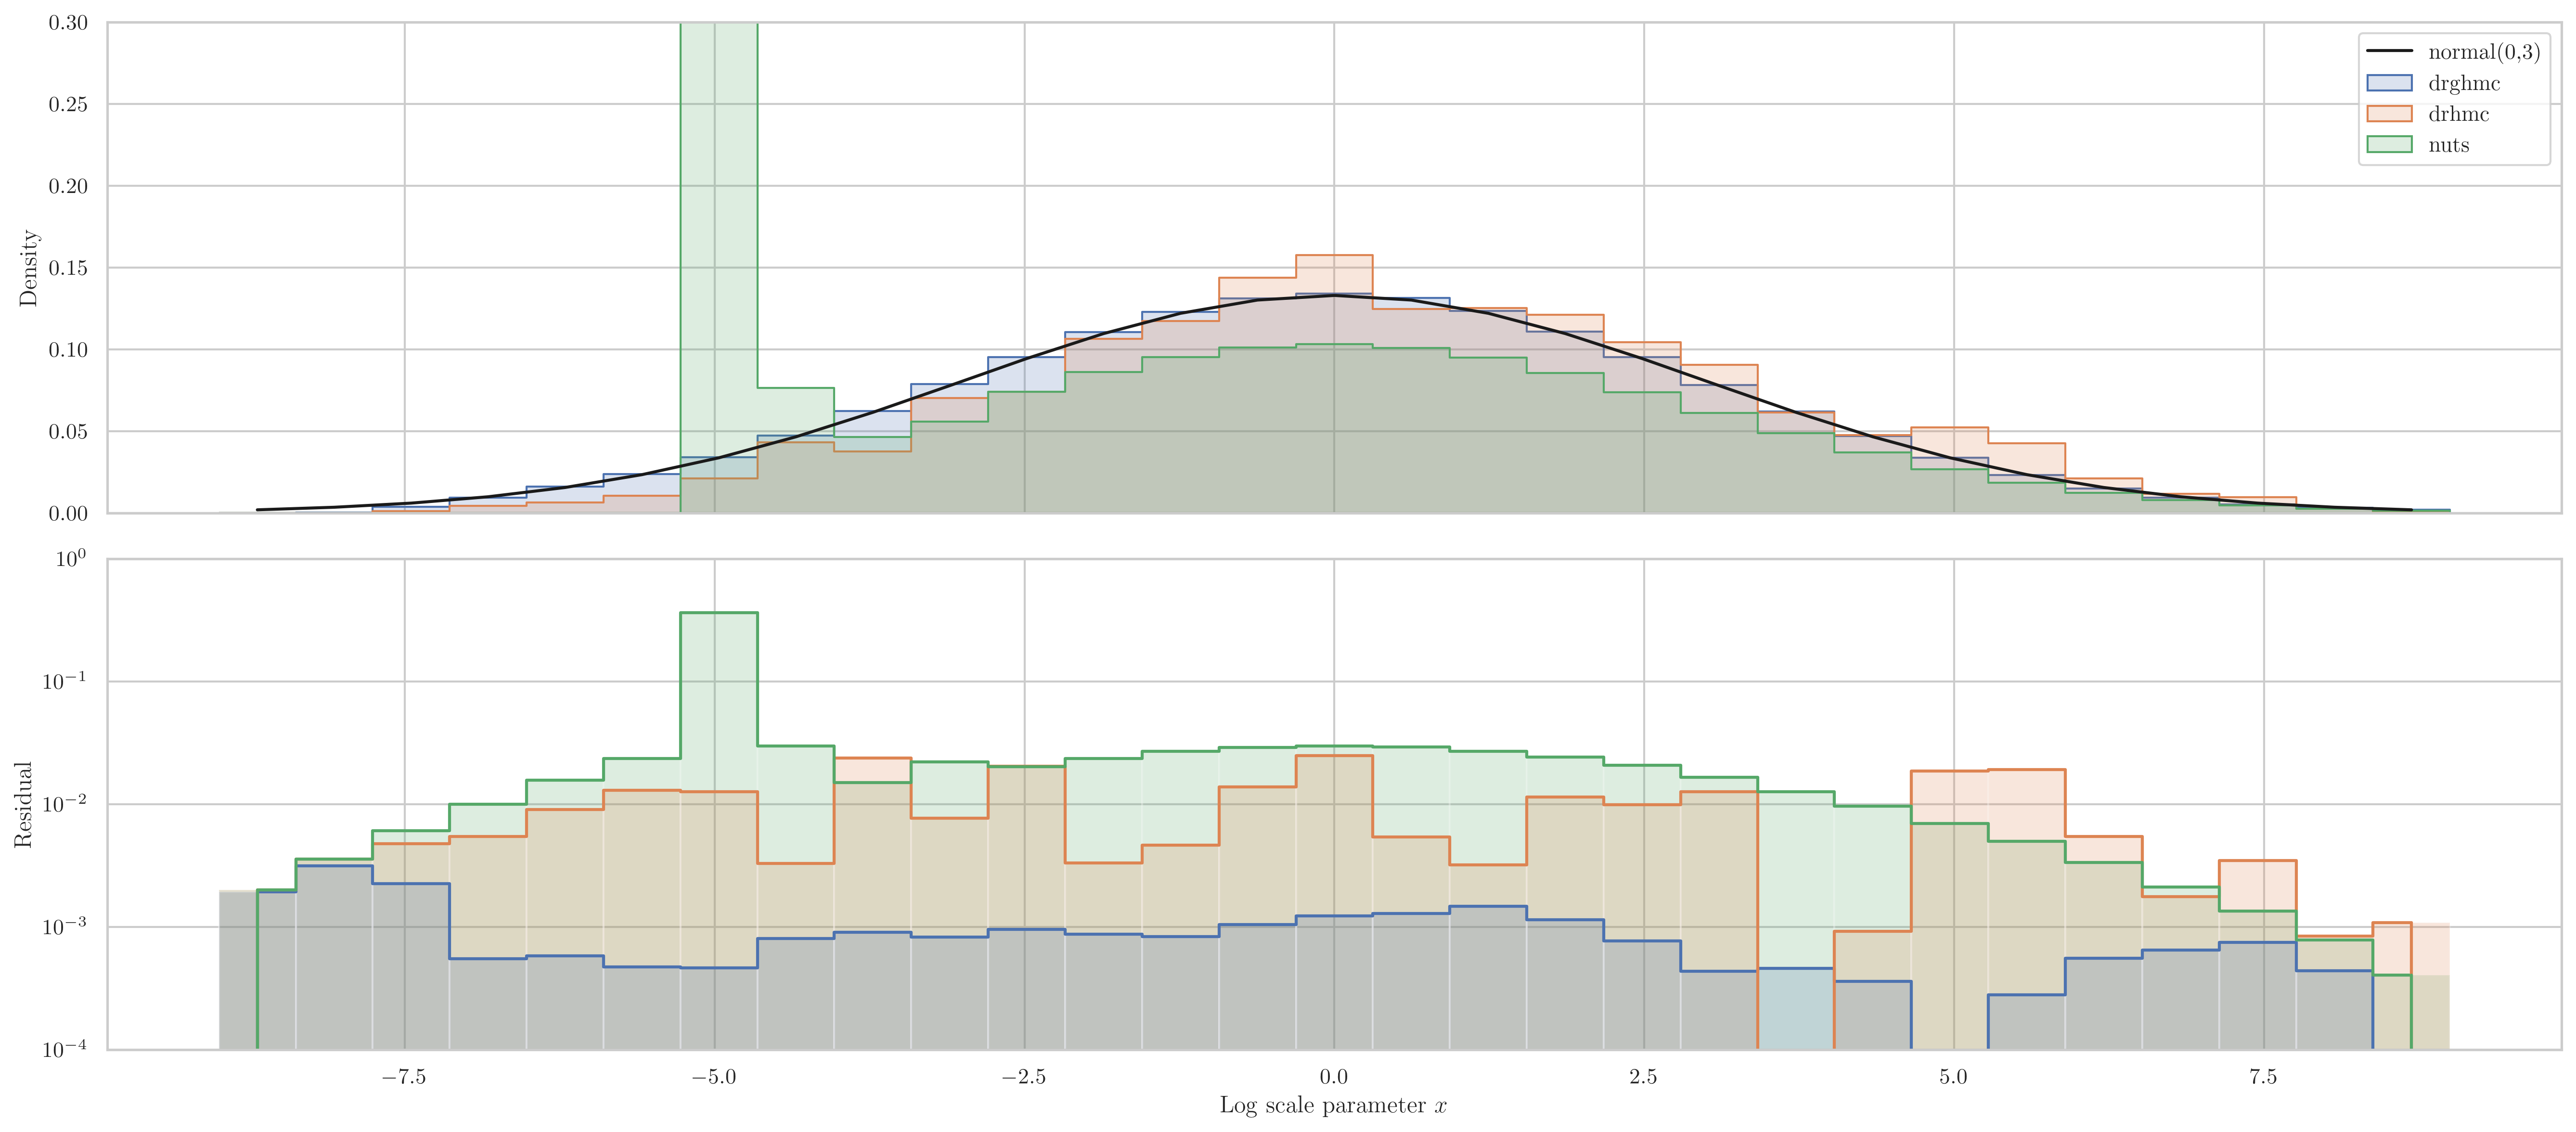

In [240]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assume drghmc_data, drhmc_data, and nuts_data are your vectors

# Step 1: Compute histogram bins using numpy
nbins = 30
bins = np.linspace(-9, 9, nbins)

# Step 2: Compute histogram values for each vector
drghmc_hist, _ = np.histogram(drghmc_data, bins=bins, density=True)
drhmc_hist, _ = np.histogram(drhmc_data, bins=bins, density=True)
nuts_hist, _ = np.histogram(nuts_data, bins=bins, density=True)

# Step 3: Compute reference normal density values
bin_centers = (bins[:-1] + bins[1:]) / 2  # compute bin centers
ref_density = np.exp(-bin_centers**2 / (2 * 3**2)) / (3 * np.sqrt(2 * np.pi))

# Step 4: Compute residuals
drghmc_residuals = np.abs(drghmc_hist - ref_density)
drhmc_residuals = np.abs(drhmc_hist - ref_density)
nuts_residuals = np.abs(nuts_hist - ref_density)

# Step 5: Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 8), sharex=True)

# Top subplot: Histograms
ax1.plot(bin_centers, ref_density, 'k-', label='normal(0,3)')
sns.histplot(ax=ax1, x=drghmc_data, stat="density", bins=bins, label="drghmc", element="step", fill=True, alpha=0.2)
sns.histplot(ax=ax1, x=drhmc_data, stat="density", bins=bins, label="drhmc", element="step", fill=True, alpha=0.2)
sns.histplot(ax=ax1, x=nuts_data, stat="density", bins=bins, label="nuts", element="step", fill=True, alpha=0.2)
ax1.set_ylim(0, 0.3)
ax1.legend()

# Bottom subplot: Residual bar plot with width matching bin width

ax2.bar(bin_centers, nuts_residuals, width=np.diff(bins), label="nuts", alpha=0.2, color='C2')
ax2.bar(bin_centers, drhmc_residuals, width=np.diff(bins), label="drhmc", alpha=0.2, color='C1')
ax2.bar(bin_centers, drghmc_residuals, width=np.diff(bins), label="drghmc", alpha=0.2, color='C0')

sns.lineplot(x=bin_centers, y=drghmc_residuals, label="drghmc", ax=ax2, drawstyle='steps-mid')
sns.lineplot(x=bin_centers, y=drhmc_residuals, label="drhmc", ax=ax2, drawstyle='steps-mid')
sns.lineplot(x=bin_centers, y=nuts_residuals, label="nuts", ax=ax2, drawstyle='steps-mid')
ax2.step([bin_centers[0], bin_centers[0]], [0, drghmc_residuals[0]], color='C0', where='mid')
ax2.step([bin_centers[0], bin_centers[0]], [0, drhmc_residuals[0]], color='C1', where='mid')
ax2.step([bin_centers[0], bin_centers[0]], [0, nuts_residuals[0]], color='C2', where='mid')
ax2.step([bin_centers[-1], bin_centers[-1]], [drghmc_residuals[-1], 0], color='C0', where='mid')
ax2.step([bin_centers[-1], bin_centers[-1]], [drhmc_residuals[-1], 0], color='C1', where='mid')
ax2.step([bin_centers[-1], bin_centers[-1]], [nuts_residuals[-1], 0], color='C2', where='mid')

ax2.set_xlabel(r'Log scale parameter $x$')
ax2.set_ylabel('Residual')
ax2.set_ylim(1e-4, 1)
ax2.set_yscale('log')
ax2.legend().remove()

plt.tight_layout()
plt.show()

In [176]:
# Step 1: Compute histogram bins using numpy
nbins = 40
bins = np.linspace(-9, 9, nbins)

# Step 2: Compute histogram values for each vector
drghmc_hist, _ = np.histogram(drghmc_data, bins=bins, density=True)
drhmc_hist, _ = np.histogram(drhmc_data, bins=bins, density=True)
nuts_hist, _ = np.histogram(nuts_data, bins=bins, density=True)

# Step 3: Compute reference normal density values
bin_centers = (bins[:-1] + bins[1:]) / 2  # compute bin centers
ref_density = np.exp(-bin_centers**2 / (2 * 3**2)) / (3 * np.sqrt(2 * np.pi))

# Step 4: Compute residuals
drghmc_residuals = np.abs(drghmc_hist - ref_density)
drhmc_residuals = np.abs(drhmc_hist - ref_density)
nuts_residuals = np.abs(nuts_hist - ref_density)

# Create a dictionary to store the data
data_dict = {
    'value': np.concatenate((drghmc_data, drhmc_data, nuts_data, drghmc_residuals, drhmc_residuals, nuts_residuals)),
    'sampler type': np.concatenate((np.repeat('drghmc', len(drghmc_data)), np.repeat('drhmc', len(drhmc_data)), np.repeat('nuts', len(nuts_data)), np.repeat("drghmc", len(drghmc_residuals)), np.repeat("drhmc", len(drhmc_residuals)), np.repeat("nuts", len(nuts_residuals)))),
    'row': np.concatenate((np.repeat('Density', len(drghmc_data) + len(drhmc_data) + len(nuts_data)), np.repeat('Residual', len(drghmc_residuals) + len(drhmc_residuals) + len(nuts_residuals))))
}

# Create a DataFrame from the dictionary
data = pd.DataFrame(data_dict)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


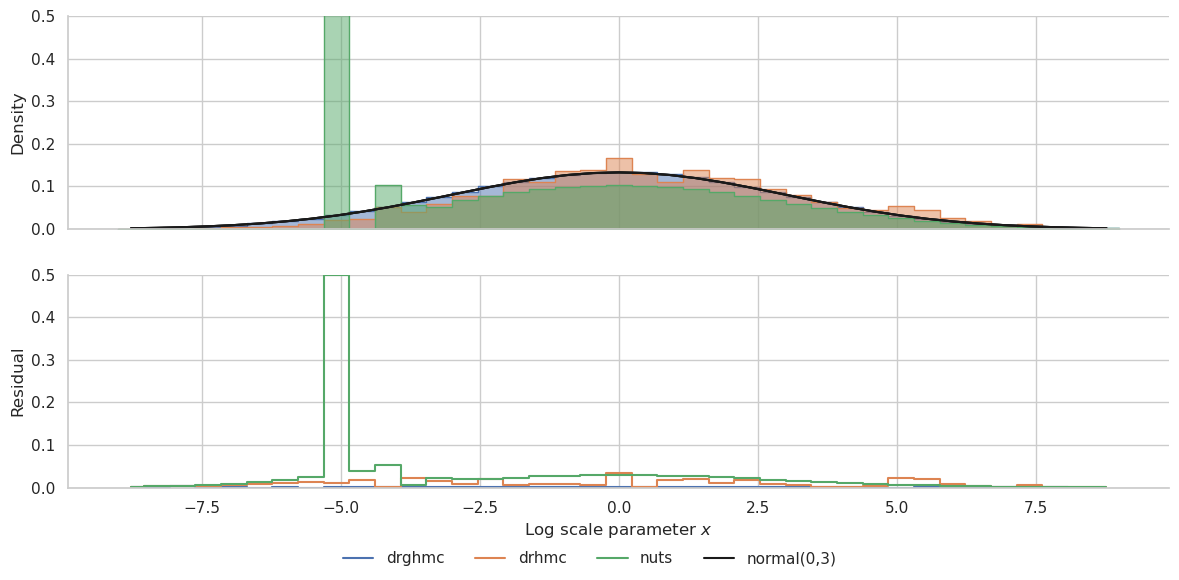

In [209]:
# Create a FacetGrid object
g = sns.FacetGrid(data, row="row", row_order=["Density", "Residual"], hue="sampler type", hue_order=['drghmc', 'drhmc', 'nuts', 'normal(0,3)'], aspect=4, sharex=True)

# Define a function for the top plot (histogram)
def top_plot(x, **kwargs):
    sns.histplot(x=x, stat="density", bins=bins, element="step", fill=True, alpha=0.5, **kwargs)
    plt.plot(bin_centers, ref_density, 'k-', label='normal(0,3)')
    ax = plt.gca()
    ax.set_ylim(0, 0.5)

# Define a function for the bottom plot (line plot)
def bottom_plot(x, **kwargs):
    sns.lineplot(x=bin_centers, y=x, drawstyle='steps-mid', **kwargs)
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 1)
    ax.set_ylabel('Residual')
    ax.set_xlabel(r'Log scale parameter $x$')

def plot_func(data, **kwargs):
    if data.row.eq('Density').any():
        top_plot(data['value'], **kwargs)
    else:
        bottom_plot(data['value'], **kwargs)

g.map_dataframe(plot_func)

# remove the axes labels
g.set_titles("")

# Add a legend
g.add_legend()
g.figure.subplots_adjust(bottom=0.15)
sns.move_legend(g, "lower center", ncol=4, title="")

# Show the plot
plt.show()

AttributeError: PolyCollection.set() got an unexpected keyword argument 'row'

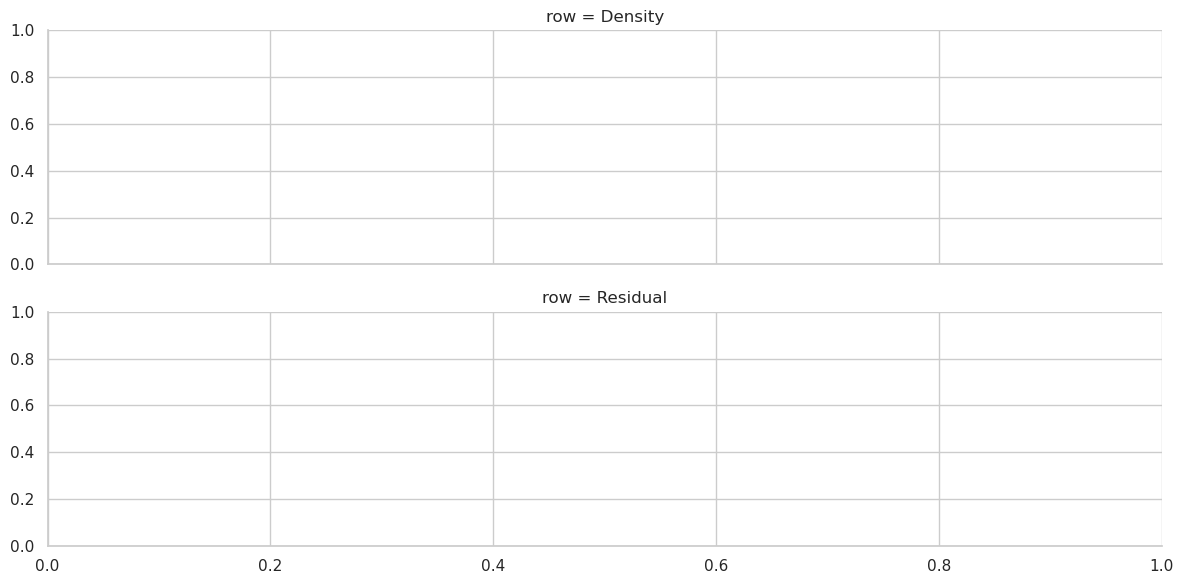

In [215]:
# Create a FacetGrid object
g = sns.FacetGrid(data, row="row", row_order=["Density", "Residual"], hue="sampler type", hue_order=['drghmc', 'drhmc', 'nuts', 'normal(0,3)'], aspect=4, sharex=True)

# Define a function for the top plot (histogram)
def top_plot(data, **kwargs):
    sns.histplot(x=data, stat="density", bins=bins, element="step", fill=True, alpha=0.5, **kwargs)
    plt.plot(bin_centers, ref_density, 'k-', label='normal(0,3)')
    ax = plt.gca()
    ax.set_ylim(0, 0.5)

# Define a function for the bottom plot (line plot)
def bottom_plot(data, **kwargs):
    sns.lineplot(x=bin_centers, y=data, drawstyle='steps-mid', **kwargs)
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 1)
    ax.set_ylabel('Residual')
    ax.set_xlabel(r'Log scale parameter $x$')

# Map the functions to the facets
g.map(top_plot, 'value', row='Density')
g.map(bottom_plot, 'value', row='Residual')

# remove the axes labels
g.set_titles("")

# Add a legend
g.add_legend()
g.figure.subplots_adjust(bottom=0.15)
sns.move_legend(g, "lower center", ncol=4, title="")

# Show the plot
plt.show()